In [0]:
import requests as rq
import json
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#Função de requisicao da api de dados de pokemons 'pokedex'
def rq_results(url,key):
    request = rq.get(url)
    
    if key != '':
        request = request.json()[key]
    else:
        request = request.json()
        
    return request
  
#Funcao que cria dataframes com limite dinamico de acordo com a disponibilizacao total de objetos fornecidos pela api
def createDataFrameRequest(url,key):
    dinamic_count = rq_results(url,'count')
    url = url+'?limit='+ str(dinamic_count)
    json_array = rq_results(url,key)
    df = spark.createDataFrame(json_array)
    
    return df;

In [0]:
#Crianda dataFrame simplificado com base na fonte de dados 'raw'
df_pokemon_raw = createDataFrameRequest('https://pokeapi.co/api/v2/pokemon/','results')
#Teste amostral dos pokemons
#df_pokemon.show(5,truncate=False)

dict_pokemon = []

#Interando colecao de pokemons
for row in df_pokemon_raw.rdd.collect():
    #Join vai ser pelo nome
    instance_atributes = rq_results(row['url'],'')
    tuple_instance = (instance_atributes['id'],instance_atributes['name'],instance_atributes['height'],row['url'],instance_atributes['is_default'])
    
    dict_pokemon.append(tuple_instance)
    
df_pokemon = spark.createDataFrame(dict_pokemon,schema=['Id','Pokemon','Altura','url','padrao'])

In [0]:
#PERGUNTA 1:
question_one = 'PERGUNTA 1: Quais são os maiores Pokémon? Exiba os Pokémon e a altura.'
#Selecionando valores máximos de alturas e exibindo maiores pokemons registrados
print(question_one)
df_pokemon.select('Pokemon','Altura').sort(desc('Altura')).show()

PERGUNTA 1: Quais são os maiores Pokémon? Exiba os Pokémon e a altura.
+--------------------+------+
|             Pokemon|Altura|
+--------------------+------+
| eternatus-eternamax|  1000|
|    centiskorch-gmax|   750|
|      duraludon-gmax|   430|
|      coalossal-gmax|   420|
|       inteleon-gmax|   400|
|        snorlax-gmax|   350|
|         meowth-gmax|   330|
|     grimmsnarl-gmax|   320|
|       alcremie-gmax|   300|
|urshifu-single-st...|   290|
|      charizard-gmax|   280|
|      rillaboom-gmax|   280|
|      cinderace-gmax|   270|
|urshifu-rapid-str...|   260|
|      hatterene-gmax|   260|
|        machamp-gmax|   250|
|       melmetal-gmax|   250|
|      blastoise-gmax|   250|
|       venusaur-gmax|   240|
|toxtricity-amped-...|   240|
+--------------------+------+
only showing top 20 rows



In [0]:
#PERGUNTA 2:
question_two = 'PERGUNTA 2: Quantos Pokémon possuem mais de um caminho evolutivo, ou seja, mais de uma segunda ou terceira forma? Informe a quantidade, tomando como base o número distinto de Pokémon na sua primeira forma.'

df_pokemon_form = createDataFrameRequest('https://pokeapi.co/api/v2/pokemon-form/','results')

#Contador de poke evolucoes informado pela key form_order maior que zero no objeto de pokemon-forms e cada objeto especicfico e em forma padrao
count_order_pokemons = 0

for row in df_pokemon_form.rdd.collect():
    instance_atributes = rq_results(row['url'],'')
    #Contando os pokemons que te evolucoes a mais que a segunda forma de pokemons em forma padrao
    if instance_atributes['is_default'] == True and instance_atributes['form_order'] > 2:
        count_order_pokemons = count_order_pokemons + 1
print(question_two)
print('O número de Pokémon com mais de um caminho evolutivo é '+ str(count_order_pokemons))

PERGUNTA 2: Quantos Pokémon possuem mais de um caminho evolutivo, ou seja, mais de uma segunda ou terceira forma? Informe a quantidade, tomando como base o número distinto de Pokémon na sua primeira forma.
O número de Pokémon com mais de um caminho evolutivo é 53


In [0]:
#PERGUNTA 3:
question_tree = 'PERGUNTA 3: Quais são os Pokémon do tipo gelo (ice) que mais fornecem experiência ao serem derrotados? Leve em consideração apenas os Pokémon que estão em sua forma padrão. Exiba os Pokémon e a experiência que é fornecida.'

dict_ice_type =[]

for row in df_pokemon_raw.rdd.collect():
    instance = rq_results(row['url'],'')
    for row_type in instance ['types']:
        if row_type['type']['name'] == 'ice':
            tuple_instance = (instance['name'],instance['base_experience'])
            #print(tuple_instance)
            dict_ice_type.append(tuple_instance)
        
df_pokemon_ice_type = spark.createDataFrame(dict_ice_type,schema=['pokemon','experiencia'])

df_pokemon_ice_type_default = df_pokemon_ice_type.join(df_pokemon, df_pokemon_ice_type.pokemon == df_pokemon.Pokemon, 'outer').filter(df_pokemon.padrao == 'true')

print(question_tree)
df_pokemon_ice_type_default.select( df_pokemon_ice_type.pokemon,'experiencia').sort(desc('experiencia')).show()

PERGUNTA 3: Quais são os Pokémon do tipo gelo (ice) que mais fornecem experiência ao serem derrotados? Leve em consideração apenas os Pokémon que estão em sua forma padrão. Exiba os Pokémon e a experiência que é fornecida.
+---------+-----------+
|  pokemon|experiencia|
+---------+-----------+
|   kyurem|        297|
|glastrier|        290|
| articuno|        261|
|   regice|        261|
|vanilluxe|        241|
|mamoswine|        239|
|  walrein|        239|
|   lapras|        187|
| cloyster|        184|
|  glaceon|        184|
|  mr-rime|        182|
|  avalugg|        180|
|cryogonal|        180|
|  weavile|        179|
|arctozolt|        177|
|  beartic|        177|
|arctovish|        177|
|abomasnow|        173|
| froslass|        168|
|   glalie|        168|
+---------+-----------+
only showing top 20 rows



In [0]:
#PERGUNTA 4:
question_four = 'PERGUNTA 4: Encontre o golpe (move) que é mais aprendido por Pokémon pelo método **level-up** e em qual versão do jogo isso acontece, levando em consideração apenas os Pokémon que estão em sua forma padrão. Em seguida, entre os Pokémon que aprendem esse golpe (por level-up e na versão do jogo encontrada no passo anterior), diga quais são os Pokémon que possuem o maior valor do atributo (stat) (attack). Exiba os Pokémon, a versão do jogo em que acontece de mais Pokémon aprenderem o golpe e qual é o valor do atributo (attack) deles.'

dict_moves = []

for row in df_pokemon.rdd.collect():
    #join vai ser pelo nome
    instance_atributes = rq_results(row['url'],'')
    #considerando pokemons em forma padrao
    if instance_atributes['is_default'] == True:
        for row_stat in instance_atributes['stats']:
            if row_stat['stat']['name'] == 'attack':
                for row_moves in instance_atributes['moves']:
                    #print(row_moves)
                    #considerando metodo de apredizado de golpe especifico
                    for row_move_details in row_moves['version_group_details']:
                        if row_move_details['move_learn_method']['name'] == 'level-up':
                            tuple_instance = (row['Pokemon'],row_stat['base_stat'],row_moves['move']['name'],row_move_details['version_group']['name'])
                            #print(tuple_instance)
                            dict_moves.append(tuple_instance)

#Exibindo resultados
df_extraction_moves_level_up = spark.createDataFrame(dict_moves,schema=['pokemon','valor_atributo','name_move','versao'])
#Filtro pokemon padrao
df_moves_default = df_extraction_moves_level_up.join(df_pokemon, df_extraction_moves_level_up.pokemon == df_pokemon.Pokemon, 'outer').filter(df_pokemon.padrao == 'true')

print(question_four)
df_moves_default.select(df_extraction_moves_level_up.pokemon ,'versao','valor_atributo').sort(desc('valor_atributo')).show(truncate=False)

PERGUNTA 4: Encontre o golpe (move) que é mais aprendido por Pokémon pelo método **level-up** e em qual versão do jogo isso acontece, levando em consideração apenas os Pokémon que estão em sua forma padrão. Em seguida, entre os Pokémon que aprendem esse golpe (por level-up e na versão do jogo encontrada no passo anterior), diga quais são os Pokémon que possuem o maior valor do atributo (stat) (attack). Exiba os Pokémon, a versão do jogo em que acontece de mais Pokémon aprenderem o golpe e qual é o valor do atributo (attack) deles.
+-------+--------------------+--------------+
|pokemon|versao              |valor_atributo|
+-------+--------------------+--------------+
|kartana|ultra-sun-ultra-moon|181           |
|kartana|ultra-sun-ultra-moon|181           |
|kartana|sun-moon            |181           |
|kartana|sun-moon            |181           |
|kartana|sun-moon            |181           |
|kartana|sun-moon            |181           |
|kartana|ultra-sun-ultra-moon|181           |
|ka

In [0]:
question_five = 'PERGUNTA 5: Quais são as 7 evoluções que geram o maior aumento em algum dos atributos? Por exemplo, um Pokémon com o stat (attack) igual a 50 evoluir para um com o stat (attack) igual a 150, o aumento seria de 100. A análise deve ser feita para todos os atributos de todos os Pokémon, e somente aqueles na sua forma padrão. Exiba a pré-evolução, a evolução, o atributo afetado e o quanto ele aumentou com a evolução.'

dict_sum_stat = []
count_stat = 0

for row in df_pokemon_raw.rdd.collect():
    instance_atributes = rq_results(row['url'],'')
    #Pokemon padrao
    if instance_atributes['is_default'] == True:
        for row_stat in instance_atributes['stats']:
            count_stat = count_stat + row_stat['base_stat'] 
    tuple_instance = (instance_atributes['id'], instance_atributes['name'],count_stat)        
    dict_sum_stat.append(tuple_instance)
    count_stat = 0

df_pokemon_stat = spark.createDataFrame(dict_sum_stat,schema=['id','name','sum_stat'])

dict_evolution = []

for row in df_pokemon_stat.rdd.collect():
    url_pokemon = 'https://pokeapi.co/api/v2/evolution-chain/' + str(row['id'])
    #Tratativa de erro contra id não associado a nenhum registro em na rota evolution_chain
    if str(rq.get(url_pokemon)) != '<Response [404]>':
        #print(row['id'])
        instance_atributes = rq_results(url_pokemon,'')
        # Se houver evolucao pokemon registra
        if instance_atributes != [] and  instance_atributes['chain']['evolves_to'] != []:
            tuple_instance = (instance_atributes['chain']['evolves_to'][0]['species']['name'],instance_atributes['chain']['species']['name'])
            dict_evolution.append(tuple_instance)

df_pokemon_evolution_stat = spark.createDataFrame(dict_evolution,schema=['evolution','before_form'])
df_pokemon_evolution_stat = df_pokemon_evolution_stat.join(df_pokemon_stat, df_pokemon_evolution_stat.before_form == df_pokemon_stat.name, 'outer')

#df_pokemon_evolution_stat.na.drop(how="any").show()
dict_diff_stat = []

#Pegando sum_state da evolucao e id da pre evolucao
for row_stat in df_pokemon_stat.rdd.collect():
    for row_evolution in df_pokemon_evolution_stat.rdd.collect():
        if row_stat['name'] == row_evolution['evolution']:
            #row_evolution['sum_stat_evolution'] = row_stat['sum_stat'] # ver um jeito de atribuir valor 
            tuple_instance = (row_evolution['id'],row_stat['sum_stat'] )
            dict_diff_stat.append(tuple_instance)

df_diff_stat = spark.createDataFrame(dict_diff_stat,schema=['id_pre_evolution','sum_stat_evolution_cmp'])   
#Pegando diferença entre pre evolucao e evolucao
df_pokemon_evolution_stat = df_pokemon_evolution_stat.join(df_diff_stat, df_pokemon_evolution_stat.id == df_diff_stat.id_pre_evolution,'outer')

print(question_five)
# a soma dos atributos de uma pre-evolucao subtraida de uma evolucao posterior do mesmo pokemon mostra qual pokemon teve mais aumento de poder
df_pokemon_evolution_stat = df_pokemon_evolution_stat.withColumn('agg_stat',(df_pokemon_evolution_stat.sum_stat_evolution_cmp - df_pokemon_evolution_stat.sum_stat))

#Teste tabela completa para conferencia dos dados
#df.na.drop(how="any").sort(desc(df.agg_stat)).show()

#Resposta final da pergunta 5
df_pokemon_evolution_stat.na.drop(how="any").sort(desc(df_pokemon_evolution_stat.agg_stat)).select('name','evolution','agg_stat').show()

PERGUNTA 5: Quais são as 7 evoluções que geram o maior aumento em algum dos atributos? Por exemplo, um Pokémon com o stat (attack) igual a 50 evoluir para um com o stat (attack) igual a 150, o aumento seria de 100. A análise deve ser feita para todos os atributos de todos os Pokémon, e somente aqueles na sua forma padrão. Exiba a pré-evolução, a evolução, o atributo afetado e o quanto ele aumentou com a evolução.
+----------+-----------+--------+
|      name|  evolution|agg_stat|
+----------+-----------+--------+
|  magikarp|   gyarados|     340|
|    feebas|    milotic|     340|
|    wimpod|  golisopod|     300|
|    meltan|   melmetal|     300|
|    noibat|    noivern|     290|
|      snom|   frosmoth|     290|
|   sunkern|   sunflora|     245|
|   tyrogue|  hitmonlee|     245|
|     riolu|    lucario|     240|
|  makuhita|   hariyama|     237|
|  fomantis|   lurantis|     230|
|    combee|  vespiquen|     230|
|   happiny|    chansey|     230|
|   milcery|   alcremie|     225|
|    

In [0]:
'''
PERGUNTA 6: - Quais são os Pokémons com maior vantagem atacante sobre outros
Pokémons? Leve em consideração apenas o tipo do Pokémon (Um Pokémon do
tipo fogo/lutador (fire/fighting) possui vantagem atacante em um
Pokémon inseto/voador (bug/flying), pois o tipo fogo tem vantagem
sobre inseto, apesar do tipo lutador não ser eficiente contra o tipo
inseto e voador) e apenas os Pokémon que estão em sua forma padrão.
Exiba os Pokémon, e a quantidade de Pokémon que eles possuem vantagem
atacante sobre.
'''
#respostar estao em no_damage_to(nao causa dano em) no_damage_from(nao sofre dano de ) da rota https://pokeapi.co/api/v2/type/{id or name} /
array_type = rq_results("https://pokeapi.co/api/v2/type/",'results')
dict_type = []

for url_type in array_type:
    instance_type = rq_results(url_type['url'],'damage_relations')
    #print(instance_type)
    if instance_type['double_damage_to'] != [] and instance_type['double_damage_from'] != []:
        tuple_instance = (url_type['name'],instance_type['double_damage_to'][0]['name'],instance_type['double_damage_from'][0]['name'])
    elif instance_type['double_damage_to'] == [] and instance_type['double_damage_from'] == []:
        tuple_instance = (url_type['name'],'','')
    elif instance_type['double_damage_to'] != [] and instance_type['double_damage_from'] == []:
        tuple_instance = (url_type['name'],instance_type['double_damage_to'][0]['name'],'')
    elif instance_type['double_damage_to'] == [] and instance_type['double_damage_from'] != []:
        tuple_instance = (url_type['name'],'',instance_type['double_damage_from'][0]['name'])
    
    dict_type.append(tuple_instance)

df_type = spark.createDataFrame(dict_type,schema=['tipo','forte_contra','fraco_contra'])
#df_type.show()

dict_pokemon_types = []

for row in df_pokemon_raw.rdd.collect():
    instance = rq_results(row['url'],'')
    for row_type in instance ['types']:
        tuple_instance = (row['name'],row_type['type']['name'])
        #print(tuple_instance)
        dict_pokemon_types.append(tuple_instance)

#Tabela de realcao de todos os tipos de pokemons podendo um ser mais de um tipo
df_pokemon_types = spark.createDataFrame(dict_pokemon_types,schema=['nome','tipo_pokemon'])
df_pokemon_types = df_pokemon_types.join(df_type, df_pokemon_types.tipo_pokemon == df_type.tipo, 'outer')
df_pokemon_types = df_pokemon_types.drop('tipo_pokemon')

dict_result = []
for row in df_pokemon_types.rdd.collect():
    #contagem da predominancia sobre o 'forte'  de um pokemon ser o 'fraco' de todos segundo o catalogo df_pokemon_types 
    tuple_instance =(row['nome'],df_pokemon_types.filter(df_pokemon_types.fraco_contra == row['forte_contra']).count())
    dict_result.append(tuple_instance)

df_dominance = spark.createDataFrame(dict_result,schema=['pokemon','predominancia'])
#dropando nomes duplicados apos a operacao de calculo
df_dominance = df_dominance.dropDuplicates().sort(desc("predominancia"))

#Teste amostral
#df_dominance.count()
#df_dominance.show()

#Filtrando pokemons padrao
df_dominance_trated = df_dominance.join(df_pokemon, df_dominance.pokemon == df_pokemon.Pokemon, 'outer').filter(df_pokemon.padrao == 'true')
#Resposta final da pergunta 6
df_dominance_trated.groupBy(df_pokemon.Pokemon).sum('predominancia').sort(desc('sum(predominancia)')).show()

+--------------------+-------------+
|             pokemon|predominancia|
+--------------------+-------------+
|             mime-jr|          430|
|              marill|          430|
|            clefairy|          430|
|            clefable|          430|
|           tapu-fini|          430|
|      hatterene-gmax|          430|
|     grimmsnarl-gmax|          430|
|           tapu-koko|          430|
|mimikyu-totem-dis...|          430|
|            magearna|          430|
|             swirlix|          430|
|        altaria-mega|          430|
|         mawile-mega|          430|
|             azurill|          430|
|             carbink|          430|
|            granbull|          430|
|          wigglytuff|          430|
|             togetic|          430|
|     floette-eternal|          430|
|     ninetales-alola|          430|
+--------------------+-------------+
only showing top 20 rows

+-------------------+------------------+
|            Pokemon|sum(predominancia)|
+---

Bonus de analise grafica da primeira pergunta proposta acima:
Out[12]: Text(0.5, 1.0, 'Relação de Altura Pokemon')

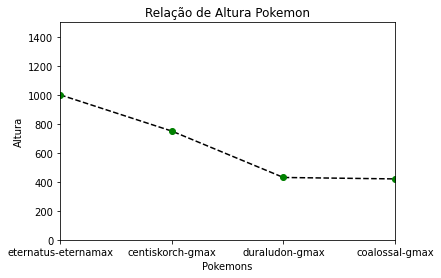

In [0]:
#BONUS
bonus_analytics = 'Bonus de analise grafica da primeira pergunta proposta acima:'
pokemon = np.concatenate(np.array(df_pokemon.select("Pokemon").sort(desc('Altura')).collect()))
altura_pokemon = np.concatenate(np.array(df_pokemon.select("Altura").sort(desc('Altura')).collect()))

#Teste amostral do array
#print(pokemon)

print(bonus_analytics)

plt.plot(pokemon,altura_pokemon,'k--')
plt.plot(pokemon,altura_pokemon,'go')
plt.xlabel('Pokemons')
plt.ylabel('Altura')
plt.xlim(0,3)#  quatro primeiros pokemons mais altos
plt.ylim(0,1500)
plt.title('Relação de Altura Pokemon')
